In [2]:
# Standard code libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
from resurfemg.data_classes.data_classes import TimeSeriesData

%matplotlib widget

In [3]:
# Define EMG signal
fs_emg = 2048
t_emg = np.array([s_t/fs_emg for s_t in range(10*fs_emg)])
y_amps = [2, 5, 12]
y_sin = np.cos((0.5* t_emg - 0.5)* 2 * np.pi)
y_sin[y_sin < 0] = 0
y_emg = np.zeros((3, len(t_emg)))
for idx, y_amp in enumerate(y_amps):
    y_rand = np.random.normal(0, 1, size=len(y_sin))
    y_rand_baseline = np.random.normal(0, 1, size=len(y_sin)) / 10
    y_t = y_amp * y_sin * y_rand + y_rand_baseline
    y_emg[idx, :] = y_t

# Define ventilator
fs_vent = 100
t_vent = np.array([s_t/fs_vent for s_t in range(10*fs_vent)])
y_vent = np.zeros((3, len(t_vent)))
for idx in range(3):
    match idx:
        case 0:
            y_block = 3*scipy.signal.square(
                (t_vent - 1)/2 * 2 * np.pi, duty=0.5)
            y_block[y_block < 0] = 0
            y_vent[idx, :] = y_block
        case 1:
            y_sin = np.sin((0.5* t_vent - 0.5)* 2 * np.pi)
            y_vent[idx, :] = y_sin
        case _:
            y_sin = np.sin((0.5* t_vent - 0.5)* 2 * np.pi)
            y_sin[y_sin < 0] = 0
            y_vent[idx, :] = y_sin


In [4]:
emg_timeseries = TimeSeriesData(y_emg, fs=fs_emg, labels=['ECG', 'EMGdi', 'EMGpara'], units=3*['uV'])
emg_timeseries.envelope(signal_type='raw')
emg_timeseries.baseline()

vent_timeseries = TimeSeriesData(y_vent, fs=fs_vent, labels=['Paw', 'F', 'Vvent'], units=['cmH2O', 'L/s', 'L'])

Text(0.5, 0, 't (s)')

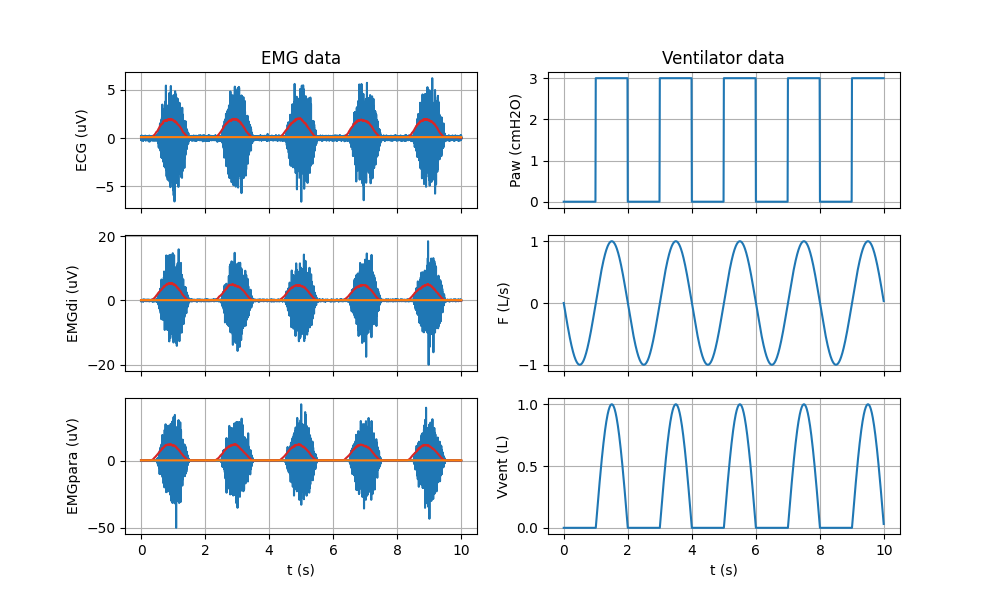

In [6]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:, 0]
colors = ['tab:red', 'tab:orange']
emg_timeseries.plot_full(axes_emg, signal_type='raw', baseline_bool=False)
emg_timeseries.plot_full(axes_emg, signal_type='env', colors=colors)
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')